In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
from skimage import measure
import re
import nibabel as nib
import tensorflow as tf
import time
from scipy.ndimage import zoom

In [5]:
!ls HGG/Brats18_2013_10_1/

Brats18_2013_10_1_flair.nii.gz	Brats18_2013_10_1_t1.nii.gz
Brats18_2013_10_1_seg.nii.gz	Brats18_2013_10_1_t2.nii.gz
Brats18_2013_10_1_t1ce.nii.gz


In [6]:
img = nib.load('HGG/Brats18_CBICA_AAB_1/Brats18_CBICA_AAB_1_flair.nii.gz')
img = img.get_fdata()

In [7]:
img.shape

(240, 240, 155)

In [8]:
img1 = nib.load('HGG/Brats18_CBICA_AAB_1/Brats18_CBICA_AAB_1_t1.nii.gz')
img1 = img1.get_fdata()

In [9]:
img2 = nib.load('HGG/Brats18_CBICA_AAB_1/Brats18_CBICA_AAB_1_t2.nii.gz')
img2 = img2.get_fdata()

In [10]:
img3 = nib.load('HGG/Brats18_CBICA_AAB_1/Brats18_CBICA_AAB_1_t1ce.nii.gz')
img3 = img3.get_fdata()

In [11]:
img4 = nib.load('HGG/Brats18_CBICA_AAB_1/Brats18_CBICA_AAB_1_seg.nii.gz')
img4 = img4.get_fdata()

Text(0.5, 1.0, 'seg')

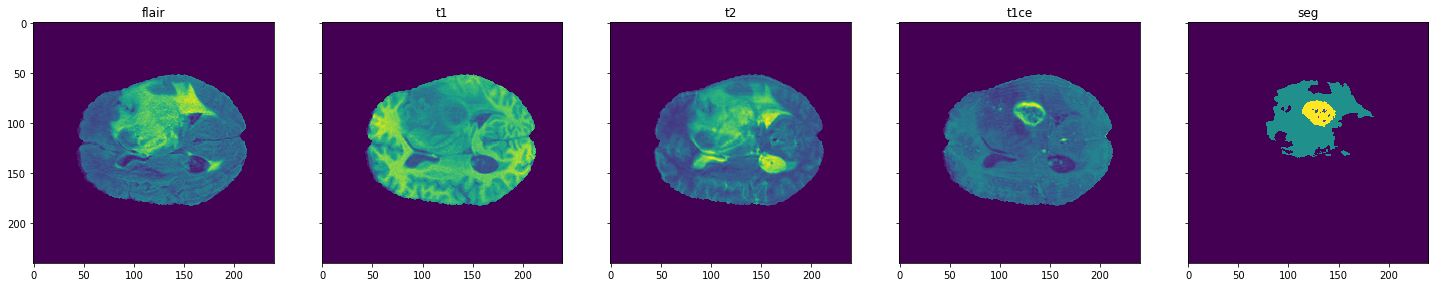

In [12]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, figsize=(25,25))
ax1.imshow(img[:,:,76])
ax1.set_title('flair')
ax2.imshow(img1[:,:,76])
ax2.set_title('t1')
ax3.imshow(img2[:,:,76])
ax3.set_title('t2')
ax4.imshow(img3[:,:,76])
ax4.set_title('t1ce')
ax5.imshow(img4[:,:,76])
ax5.set_title('seg')

In [13]:
def H_brain(scan, tumour):
    """
    Returns healthy brain voxels
    Args:
    scan - full scan
    tumor - segmented tumour
    """
    return np.logical_and(scan, np.logical_not(tumour))

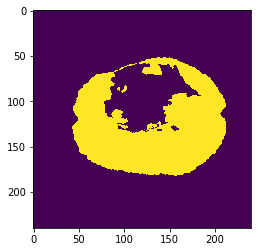

In [14]:
imgtest = np.logical_and(img3[:,:,76], np.logical_not(img4[:,:,76]))
plt.imshow(imgtest)

In [15]:
h_img = H_brain(img3, img4)

Text(0.5, 1.0, 'GD-enhancing tumor, 4, t1ce')

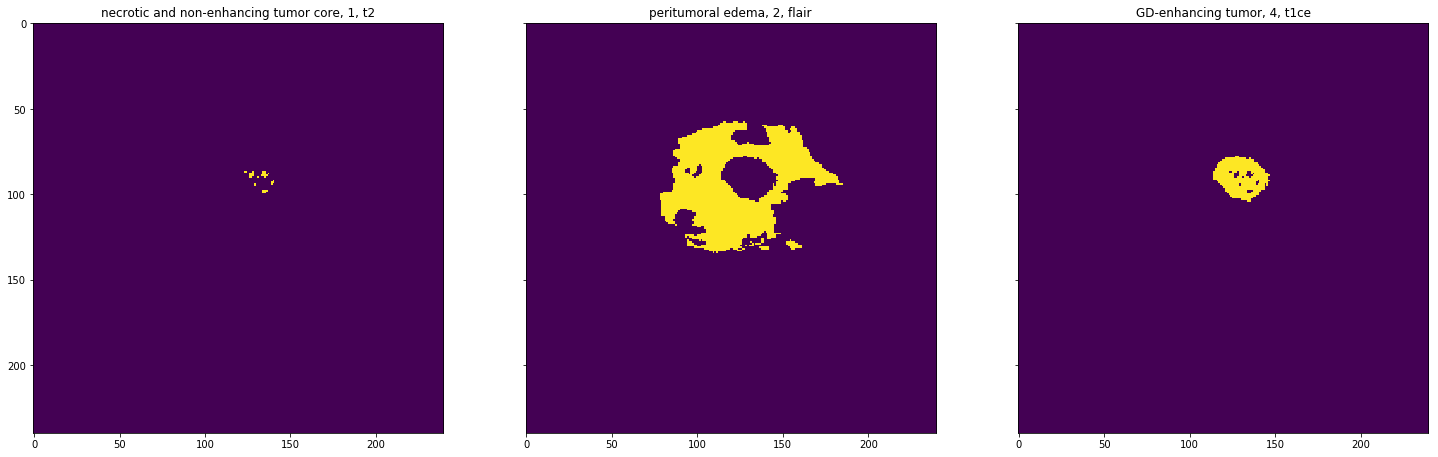

In [16]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(25,25))
ax1.imshow(img4[:,:,76] == 1)
ax1.set_title("necrotic and non-enhancing tumor core, 1, t2")
ax2.imshow(img4[:,:,76] == 2)
ax2.set_title("peritumoral edema, 2, flair")
ax3.imshow(img4[:,:,76] == 4)
ax3.set_title("GD-enhancing tumor, 4, t1ce")


In [17]:
def get_obj(tumor_array, fname='out.obj'):
    verts, faces, normals, values = measure.marching_cubes_lewiner(tumor_array, 0)
    faces = faces + 1
    thefile = open(fname, 'w')
    for item in verts:
        thefile.write("v {0} {1} {2}\n".format(item[0],item[1],item[2]))

    for item in normals:
        thefile.write("vn {0} {1} {2}\n".format(item[0],item[1],item[2]))

    for item in faces:
        thefile.write("f {0}//{0} {1}//{1} {2}//{2}\n".format(item[0],item[1],item[2]))  

    thefile.close()

In [18]:
get_obj(img1, 'brain.obj')
get_obj(img4==1, 'necrotic and non-enhancing tumor core.obj')
get_obj(img4==2, 'peritumoral edema.obj')
get_obj(img4==4, 'GD-enhancing tumor.obj')
get_obj(h_img, 'Healthy_brain.obj')


In [69]:
import subprocess
folders = subprocess.check_output("ls ./HGG/", shell=True)
folders = folders.decode().split("\n")
folders.pop()

scan_list = []

for folder in folders:
    sc = subprocess.check_output("ls ./HGG/" + str(folder), shell=True)
    sc = sc.decode().split("\n")
    sc.pop()
    sc = ["./HGG/"+str(folder)+"/" +i for i in sc]
    scan_list.append(tuple(sc))

In [70]:
flair_scans = []
for i in scan_list:
    for _ in i:
        if "flair" in _:
            scan = _
        if "seg" in _:
            seg = _
    flair_scans.append((scan, seg))
flair_scans[0]

('./HGG/Brats18_2013_10_1/Brats18_2013_10_1_flair.nii.gz',
 './HGG/Brats18_2013_10_1/Brats18_2013_10_1_seg.nii.gz')

In [73]:
t1ce_scans = []
for i in scan_list:
    for _ in i:
        if "t1ce" in _:
            scan = _
        if "seg" in _:
            seg = _
    t1ce_scans.append((scan, seg))
t1ce_scans[-1]

('./HGG/Brats18_TCIA08_469_1/Brats18_TCIA08_469_1_t1ce.nii.gz',
 './HGG/Brats18_TCIA08_469_1/Brats18_TCIA08_469_1_seg.nii.gz')

In [26]:
t2_scans = []
for i in scan_list:
    for _ in i:
        if "t2" in _:
            scan = _
        if "seg" in _:
            seg = _
    t2_scans.append((scan, seg))
t2_scans[0]

In [28]:
def get_scan(scan_path='HGG/Brats18_CBICA_AAB_1/Brats18_CBICA_AAB_1_seg.nii.gz'):
    x = nib.load(scan_path).get_fdata()[:,:,:]
    return np.expand_dims(np.append(x, np.zeros((240,240,5)), axis=-1), axis=-1)
def get_seg(scan_path='HGG/Brats18_CBICA_AAB_1/Brats18_CBICA_AAB_1_seg.nii.gz', contrast=1):
    x = nib.load(scan_path).get_fdata()==contrast
    return np.expand_dims(np.append(x, np.zeros((240,240,5)), axis=-1), axis=-1)

In [29]:
def show_scan(scan='HGG/Brats18_CBICA_AAB_1/Brats18_CBICA_AAB_1_seg.nii.gz'):
    plt.imshow(get_scan(scan)[:,:,76])
def show_seg(scan='HGG/Brats18_CBICA_AAB_1/Brats18_CBICA_AAB_1_seg.nii.gz', contrast=1):
    plt.imshow(get_seg(scan)[:,:,76]==contrast)

In [30]:
def generate_set(scans, contrast=1):
    for scan in scans:
        (x, y) = scan
        x = get_scan(x)
        y = get_seg(y, contrast)
        yield x, y

In [31]:
n = 0
t0 = time.time()
for i in generate_set(t1ce_scans):
    n += 1
print(n)
print("Time:", time.time() - t0)

210
Time: 40.7288453578949


In [32]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dropout, concatenate, Flatten, Dense, Reshape, BatchNormalization, Activation
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Conv3D, Conv3DTranspose, UpSampling3D
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
import seaborn as sns

In [33]:
def BatchActivate(x):
    x = Activation('relu')(x)
    return x

def conv_block(x, filters, size, strides=(1,1,1), padding='same', activation=True):
    x = Conv3D(filters, (size,size,size), strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def pool_block(x, size):
    return MaxPooling3D((size, size, size))(x)

def upsam_block(x, size):
    return UpSampling3D((size, size, size))(x)

def res_block(blockInput, num_filters, size, batch_activate = False):
    x = BatchActivate(blockInput)
    x = conv_block(x, num_filters, size)
    x = conv_block(x, num_filters, size, activation=True)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

In [34]:
h = np.random.rand(240,240,152)
h = np.expand_dims(h, axis=0)
h = np.expand_dims(h, axis=-1)
h = tf.constant(h, dtype=tf.float16)
h.shape

TensorShape([Dimension(1), Dimension(240), Dimension(240), Dimension(152), Dimension(1)])

In [35]:
pool_block(h, 4)

<tf.Tensor 'max_pooling3d/MaxPool3D:0' shape=(1, 60, 60, 38, 1) dtype=float16>

In [36]:
def build_model(inputs, start_filters=8, filter_size=2, pool_size=2):
    #240 -> 120
    #152 -> 76
    conv1 = conv_block(inputs, start_filters, filter_size)
    conv1 = conv_block(conv1, start_filters, filter_size)
    pool1 = pool_block(conv1, pool_size)
    
    #120 -> 60
    #76 -> 38
    conv2 = conv_block(pool1, start_filters*2, filter_size)
    conv2 = conv_block(conv2, start_filters*2, filter_size)
    pool2 = pool_block(conv2, pool_size)
    
    #60 -> 30
    #38 -> 19
    conv3 = conv_block(pool2, start_filters*4, filter_size)
    conv3 = conv_block(conv3, start_filters*4, filter_size)
    pool3 = pool_block(conv3, pool_size)
    
    conv4 = conv_block(pool3, start_filters*8, filter_size)
    conv4 = conv_block(conv4, start_filters*8, filter_size)

    conv5 = upsam_block(conv4, pool_size)
    conv5 = concatenate([conv3, conv5])
    conv5 = conv_block(conv5, start_filters*4, filter_size)
    conv5 = conv_block(conv5, start_filters*4, filter_size)
    
    conv6 = upsam_block(conv5, pool_size)
    conv6 = concatenate([conv2, conv6])
    conv6 = conv_block(conv6, start_filters*2, filter_size)
    conv6 = conv_block(conv6, start_filters*2, filter_size)
    
    conv7 = upsam_block(conv6, pool_size)
    conv7 = concatenate([conv1, conv7])
    conv7 = conv_block(conv7, start_filters, filter_size)
    conv7 = conv_block(conv7, start_filters, filter_size)
    
    output = conv_block(conv7, 1, filter_size)
    
    return output

In [37]:
build_model(h, 8, 2, 2)

<tf.Tensor 'activation_14/Relu:0' shape=(1, 240, 240, 152, 1) dtype=float16>

In [38]:
inputs = Input((240,240,160,1))
outputs = build_model(inputs, 16)
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 160 0                                            
__________________________________________________________________________________________________
conv3d_15 (Conv3D)              (None, 240, 240, 160 144         input_1[0][0]                    
__________________________________________________________________________________________________
activation_15 (Activation)      (None, 240, 240, 160 0           conv3d_15[0][0]                  
__________________________________________________________________________________________________
conv3d_16 (Conv3D)              (None, 240, 240, 160 2064        activation_15[0][0]              
__________________________________________________________________________________________________
activation